In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
import tqdm

import sys
sys.path.insert(1, r'C:\Users\axeli\Desktop\Github\first-child\Python')

import agents, environment

## Part 1. Problem Definition

## Part 2. Data Download and Analysis

In [2]:
from datetime import datetime, timedelta

tickers = ['^DJI', 'GLD']

start_date = '2020-01-01'
end_date = '2024-06-30'
#end_date = (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')


data = yf.download(tickers, start = start_date, end = end_date, group_by= 'ticker')
adjc = data.iloc[:, data.columns.get_level_values(1) == 'Adj Close'].droplevel(1, axis = 1)

adjc

[*********************100%%**********************]  2 of 2 completed


Ticker,GLD,^DJI
Date,,
2020-01-02,143.949997,28868.800781
2020-01-03,145.860001,28634.880859
2020-01-06,147.389999,28703.380859
2020-01-07,147.970001,28583.679688
2020-01-08,146.860001,28745.089844
...,...,...
2024-06-24,215.630005,39411.210938
2024-06-25,214.559998,39112.160156
2024-06-26,212.580002,39127.800781


In [3]:
train1_adjc = adjc.loc[adjc.index < '2023-12-31']
train1_logret = np.log(train1_adjc) - np.log(train1_adjc.shift(1))
test1_adjc = adjc.loc[adjc.index >= '2023-12-31']

train1_logret.corr()

Ticker,GLD,^DJI
Ticker,,
GLD,1.000000,0.124865
^DJI,0.124865,1.000000


### Optimal Weights scraping
Calculate optimal weights using historical data from 01-01-2010 to 31-12-2022

In [4]:
from scipy.optimize import minimize


#test1_logret = np.log(test1_adjc) - np.log(test1_adjc.shift(1))

# Function to calculate expected return, expected volatility and expected sharpe ratio
def get_ret_vol_sr(weights):

    #Takes in weights and returns back an array of mean return, mean volatility and sharpe ratio

    weights = np.array(weights)
    ret = np.sum(train1_logret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(train1_logret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

# We multiply Shrape Ratio for -1 since we will use a minimization function
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# The function will return 0 if the sum of weights is 1
def check_sum(weights):
    return np.sum(weights) - 1

cons = ({'type':'eq','fun': check_sum})
bounds = ((0,1),)*len(tickers)

init_weights = [1/len(tickers)]*len(tickers)

opt_resutls = minimize(neg_sharpe, init_weights, method='SLSQP', bounds = bounds, constraints = cons)

# Get the optimal weights
opt_weights = opt_resutls.x

### First Simulation - Buy and Hold

Final Capital: 110231.26
Gain %: 10.23


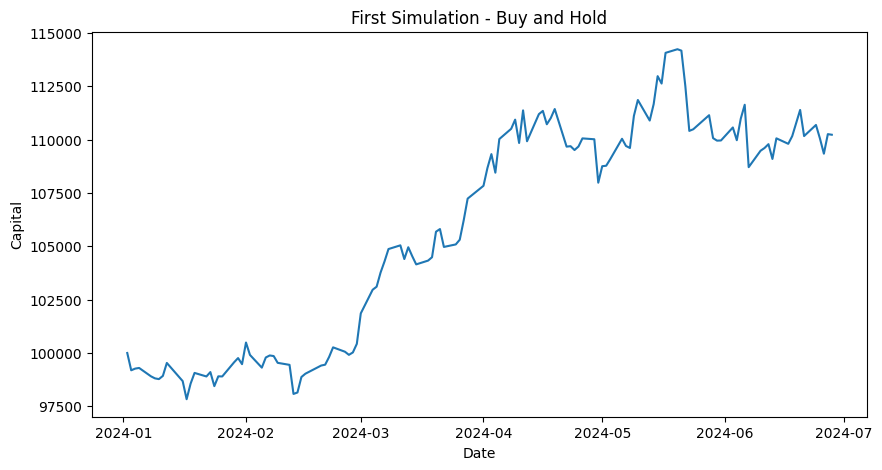

In [5]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))

PORTFOLIO_VAL = 100000

# Get the cumulative return of the portfolio with the optimal weights
test1_portfolio_daily_ret = (test1_adjc.pct_change() * opt_weights).sum(axis = 1)
buy_and_hold = ((test1_portfolio_daily_ret + 1).cumprod()) * PORTFOLIO_VAL

ax.plot(buy_and_hold)
ax.set_title("First Simulation - Buy and Hold")
ax.set_ylabel("Capital")
ax.set_xlabel("Date")

print(f"Final Capital: {buy_and_hold.iloc[-1]:.2f}\nGain %: {(buy_and_hold.iloc[-1]/PORTFOLIO_VAL-1)*100:.2f}")

In [6]:
dfs = []
for s in [1, 2, 3]:
    d = adjc.pct_change(s)
    d.columns = [f"{n}-{s}" for n in d.columns]
    dfs.append(d)

X = pd.concat(dfs, axis = 1).iloc[3:]
y = adjc.pct_change(1).iloc[4:]

X_train = X.loc[X.index < '2023-12-31']
X_test = X.loc[X.index >= '2023-12-31']
y_train = y.loc[y.index < '2023-12-31']
y_test = y.loc[y.index >= '2023-12-31']

X_train

,GLD-1,^DJI-1,GLD-2,^DJI-2,GLD-3,^DJI-3
Date,,,,,,
2020-01-07,0.003935,-0.004170,0.014466,-0.001788,0.027926,-0.009876
2020-01-08,-0.007502,0.005647,-0.003596,0.001453,0.006856,0.003849
2020-01-09,-0.005652,0.007369,-0.013111,0.013057,-0.009227,0.008832
2020-01-10,0.006026,-0.004598,0.000340,0.002737,-0.007164,0.008400
2020-01-13,-0.007419,0.002889,-0.001438,-0.001722,-0.007082,0.005634
...,...,...,...,...,...,...
2023-12-22,0.004434,-0.000491,0.011536,0.008197,0.006028,-0.004578
2023-12-26,0.007621,0.004263,0.012089,0.003769,0.019245,0.012495
2023-12-27,0.004538,0.002962,0.012193,0.007237,0.016682,0.006742


In [15]:
env = environment.PortfolioEnv(len(tickers), X_train, y_train)  # Initialize the custom trading environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = agents.DDQNAgent(state_size, action_size)

#with tqdm.tqdm(range(10), unit='episode') as tq_ep:
for ep in range(20):
    #tq_ep.set_description(f"Episode: {ep + 1}")
    
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    i = 0

    #print(state)

    with tqdm.tqdm(range(len(X_train)+ 10), unit = 'train') as tq_time:
        for time in tq_time:
            tq_time.set_description(f"Episode: {0}, Time: {i}, Epsilon: {agent.epsilon:.4}. Target Model Updated {i%10} steps ago")
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action, render = False)
            #print(agent.model.predict(state, verbose = 0).sum())
            next_state = np.reshape(next_state, [1, state_size])
            #print(action, env.current_weights)
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            #print(f"\r{env.returns.index[env.current_step-1]}", end = '')

            if done:
                print(f"\nEpisode: {e+1}/{20}, Epsilon: {agent.epsilon:.2}")
                break
                
            if len(agent.memory) > 30:
                agent.replay(15)
            
            i += 1

            
            if i % 10 == 0:
                agent.update_target_model()
    
    agent.save(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model", ep)


c:\Users\axeli\Desktop\Github\first-child\.first-child-venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Episode: 0, Time: 59, Epsilon: 0.8647. Target Model Updated 9 steps ago:   6%|▌         | 59/1013 [01:53<56:07,  3.53s/train]  

In [ ]:
agent.save(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model", 0)
agent.load(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model")

AttributeError: 'Sequential' object has no attribute 'load_model'

In [12]:
from collections import deque
deque(pd.read_pickle(r"C:\Users\axeli\Desktop\Github\first-child\Models\First Model\memory.pkl").to_records(index = False)), agent.memory

(deque([(array([[-0.00417028,  0.00393515, -0.00178807,  0.01446593, -0.00987644,
                 0.02792639,  0.33333333,  0.33333333,  0.33333333]]), 58, 0.00245255, array([[ 0.00564693, -0.00750152,  0.0014531 , -0.00359589,  0.00384877,
                 0.00685589,  0.7       ,  0.2       ,  0.1       ]]), False),
        (array([[ 0.00564693, -0.00750152,  0.0014531 , -0.00359589,  0.00384877,
                 0.00685589,  0.7       ,  0.2       ,  0.1       ]]), 16, -0.00208897, array([[ 0.00736858, -0.00565165,  0.01305713, -0.01311078,  0.00883239,
                -0.00922722,  0.1       ,  0.5       ,  0.4       ]]), False),
        (array([[ 0.00736858, -0.00565165,  0.01305713, -0.01311078,  0.00883239,
                -0.00922722,  0.1       ,  0.5       ,  0.4       ]]), 5, 0.0030131, array([[-4.59755214e-03,  6.02619250e-03,  2.73715226e-03,
                 3.40481081e-04,  8.39954290e-03, -7.16359769e-03,
                 0.00000000e+00,  5.00000000e-01,  5.00000000e-0

In [ ]:
Action_discretization(3, 10)

(66,
 {0: array([0., 0., 1.]),
  1: array([0. , 0.1, 0.9]),
  2: array([0. , 0.2, 0.8]),
  3: array([0. , 0.3, 0.7]),
  4: array([0. , 0.4, 0.6]),
  5: array([0. , 0.5, 0.5]),
  6: array([0. , 0.6, 0.4]),
  7: array([0. , 0.7, 0.3]),
  8: array([0. , 0.8, 0.2]),
  9: array([0. , 0.9, 0.1]),
  10: array([0., 1., 0.]),
  11: array([0.1, 0. , 0.9]),
  12: array([0.1, 0.1, 0.8]),
  13: array([0.1, 0.2, 0.7]),
  14: array([0.1, 0.3, 0.6]),
  15: array([0.1, 0.4, 0.5]),
  16: array([0.1, 0.5, 0.4]),
  17: array([0.1, 0.6, 0.3]),
  18: array([0.1, 0.7, 0.2]),
  19: array([0.1, 0.8, 0.1]),
  20: array([0.1, 0.9, 0. ]),
  21: array([0.2, 0. , 0.8]),
  22: array([0.2, 0.1, 0.7]),
  23: array([0.2, 0.2, 0.6]),
  24: array([0.2, 0.3, 0.5]),
  25: array([0.2, 0.4, 0.4]),
  26: array([0.2, 0.5, 0.3]),
  27: array([0.2, 0.6, 0.2]),
  28: array([0.2, 0.7, 0.1]),
  29: array([0.2, 0.8, 0. ]),
  30: array([0.3, 0. , 0.7]),
  31: array([0.3, 0.1, 0.6]),
  32: array([0.3, 0.2, 0.5]),
  33: array([0.3, 0.3

## Part 3 - Create the DRL model

In [ ]:
import tensorflow as tf

# Set TensorFlow to use GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError as e:
        print(e)


In [ ]:
def train_ddqnper(episodes):
    env = environment.PortfolioEnv(len(tickers), adjc.iloc[:100], adjc.iloc[:100].pct_change())  # Initialize the custom trading environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    agent = agents.DDQN_PER_Agent(state_size, action_size)

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        for time in range(500):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            reward = reward if not done else -10
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            if done:
                agent.update_target_model()
                print(f"Episode {e+1}/{episodes}, score: {time}, e: {agent.epsilon:.2}")
                break
            agent.replay()
        if e % 10 == 0:
            agent.save(f"ddqn_weights_{e}.h5")
            
    return agent

In [ ]:
agent_trained = train_ddqnper(5)

1/99	 Portfolio Value: 101100.51

TypeError: object of type 'PrioritizedReplayBuffer' has no len()

In [ ]:
def train_ddqn(episodes):
    env = environment.PortfolioEnv(len(tickers), adjc.iloc[:100], adjc.iloc[:100].pct_change())  # Initialize the custom trading environment
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    agent = agents.DDQNAgent(state_size, action_size)

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        for time in range(env.max_steps):  # Set a limit for the number of steps per episode
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action, render = True)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                agent.update_target_model()  # Update target model weights
                print(f"Episode: {e+1}/{episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}")
                break

            agent.replay(20)  # Train the agent with experience replay

    return agent

In [ ]:
trained_agent = train_ddqn(5)
#agents.DDQNAgent(3, 3)

C:\Users\axeli\AppData\Local\Temp\ipykernel_17500\3060608928.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  env = environment.PortfolioEnv(len(tickers), adjc.iloc[:100], adjc.iloc[:100].pct_change())  # Initialize the custom trading environment
c:\Users\axeli\Desktop\Github\first-child\.first-child-venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


DDQN Agent Created
99/99	 Portfolio Value: 66109.45Episode: 1/5, Score: 98, Epsilon: 0.67
99/99	 Portfolio Value: 66109.45Episode: 2/5, Score: 98, Epsilon: 0.41
99/99	 Portfolio Value: 66109.45Episode: 3/5, Score: 98, Epsilon: 0.25
99/99	 Portfolio Value: 66109.45Episode: 4/5, Score: 98, Epsilon: 0.15
99/99	 Portfolio Value: 66109.45Episode: 5/5, Score: 98, Epsilon: 0.094


In [ ]:
import agents

#agents.DQNAgent(3, 3)
import inspect
inspect.getmembers(agents)

#agents.DDQNAgent(3, 3)

[('Adam', keras.src.optimizers.adam.Adam),
 ('DDQNAgent', agents.DDQNAgent),
 ('DQNAgent', agents.DQNAgent),
 ('Dense', keras.src.layers.core.dense.Dense),
 ('Sequential', keras.src.models.sequential.Sequential),
 ('__builtins__',
  {'__name__': 'builtins',
   '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
   '__package__': '',
   '__loader__': _frozen_importlib.BuiltinImporter,
   '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>, origin='built-in'),
   '__build_class__': <function __build_class__>,
   '__import__': <function __import__>,
   'abs': <function abs(x, /)>,
   'all': <function all(iterable, /)>,
   'any': <function any(iterable, /)>,
   'ascii': <function ascii(obj, /)>,
   'bin': <function bin(number, /)>,
   'breakpoint': <function breakpoint>,
   'callable': <function callable(obj, /)>,
   'chr': <function chr(i, /)>,
   'compile': <f

In [ ]:
# import TensorFlow
import tensorflow as tf

#Check the version of TensorFlow you are using
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.17.0
[]


In [ ]:


def train_dqn(episodes):
    env = PortfolioEnv(len(tickers), adjc.iloc[:100], adjc.iloc[:100].pct_change())
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]

    agent = DDQNAgent(state_size, action_size)

    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        for time in range(len(data)):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action, render = True)
            next_state = np.reshape(next_state, [1, state_size])
            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                print(f"\nEpisode: {e+1}/{episodes}, Score: {time}, Epsilon: {agent.epsilon:.2}")
                break

            if len(agent.memory) > 10:
                agent.replay(10)

    return agent


In [ ]:
import numpy as np
import pandas as pd
import gymnasium as gym
import matplotlib.pyplot as plt
import matplotlib

class PortfolioEnv(gym.Env):
    metadata = {'render.modes' : ['human']}

    def __init__(self, n_assets: int, data: pd.DataFrame, returns: pd.DataFrame, capital:int = 100000):

        super(PortfolioEnv, self).__init__()

        self.n_assets = n_assets
        self.data = data
        self.returns = returns
        self.np_random = 10

        # Render Chart values
        # self.fig, self.ax = plt.subplots(1, 1)
        # self.chart = plt.plot([0],[0])[0]

        # Set initial weights
        self.initial_weights = np.ones(self.n_assets) / self.n_assets
        self.current_weights = self.initial_weights

        # Define capital of the portfolio
        self.starting_capital = capital
        self.capital = capital
        self.capital_x = [self.returns.index[0]]                 # Capital History - Date
        self.capital_y = [self.capital]                 # Capital History - Value


        # Actions are represented by portfolio weights
        self.action_space = gym.spaces.Box(low = 0, high = 1, shape = (n_assets, ), dtype=np.float32)

        # Observations are OHLC values (should be added market indicators and forecasted values)
        self.observation_space = gym.spaces.Box(low = -np.inf, high = np.inf, shape = (len(data.columns) + n_assets, ), dtype=np.float32)

        self.current_step = 0
        self.max_steps = len(self.data) - 1
        # self.current_state = self.data.iloc[self.current_step]
        # print(self.returns)

    def _next_observation(self):

        # Calculate percentuale variation in prices (this code is usefull only if you take adjusted close as input)
        obs = np.concatenate((self.data.iloc[self.current_step].values/self.data.iloc[self.current_step - 1]. values, self.current_weights))

        return obs

    # Check this function
    def reset(self):

        self.capital_x = []
        self.capital_y = []

        self.current_step = 0
        self.current_weights = self.initial_weights
        self.capital = self.starting_capital

        return self._next_observation()

    def step(self, action: list, render = True):

        self.current_step += 1
        self.weights = action/np.sum(action)

        reward = (self.returns.iloc[self.current_step]*self.current_weights).sum()

        self.capital = self.capital * (1 + reward)
        self.capital_x.append(self.returns.index[self.current_step])
        self.capital_y.append(self.capital)

        done = self.current_step >= self.max_steps

        obs = self._next_observation()

        if render:
            self.render()

        return obs, reward, done, {}

    def render(self, mode = 'human'):

        print(f"\r{self.current_step}/{self.max_steps}\t Portfolio Value: {self.capital:.2f}", end = "")

    def update_chart(self):

        pass

    def close(self):
        pass

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random
from collections import deque

class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Replay memory
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01  # Minimum exploration rate
        self.epsilon_decay = 0.995  # Decay rate for exploration
        self.gamma = 0.95  # Discount factor
        self.learning_rate = 0.001  # Learning rate for the neural network
        self.model = self._build_model()  # Build the neural network
        self.target_model = self._build_model()  # Build the target network
        self.update_target_model()  # Initialize target model weights

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))  # Input layer
        model.add(Dense(24, activation='relu'))  # Hidden layer
        model.add(Dense(self.action_size, activation='softmax'))  # Output layer to ensure valid portfolio weights
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))  # Compile the model
        return model

    def update_target_model(self):
        # Copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))  # Store experience

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.dirichlet(np.ones(self.action_size), size=1)[0]  # Random portfolio weights
        act_values = self.model.predict(state, verbose = 0)  # Predict portfolio weights
        return act_values[0]

    def replay(self, batch_size):

        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)

        for state, action, reward, next_state, done in minibatch:
            target = self.model.predict(state, verbose = 0)
            if done:
                target[0] = reward
            else:
                t = self.target_model.predict(next_state, verbose = 0)[0]
                target[0] = reward + self.gamma * np.amax(t)
            self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay  # Decay exploration rate

    def load(self, name):
        self.model.load_weights(name, verbose = 0)

    def save(self, name):
        self.model.save_weights(name)